In [127]:
import numpy as np
import pandas as pd
# settings to display all columns
pd.set_option("display.max_columns", None)
import matplotlib.pyplot as plt
import seaborn as sns

from category_encoders.count import CountEncoder
from category_encoders.one_hot import OneHotEncoder
from category_encoders.cat_boost import CatBoostEncoder

from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import roc_auc_score, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import GridSearchCV

In [80]:
df = pd.read_csv('../../data/data_cleaned.csv')

In [81]:
X = df.drop(columns='non_functional')
y = df['non_functional']

In [82]:
num_cols = []
sm_cat_cols = []
lg_cat_cols = []

for c in X.columns:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X[c].nunique() < 25:
        sm_cat_cols.append(c)
    else:
        lg_cat_cols.append(c)

In [83]:
X_train, X_holdout, y_train, y_holdout = train_test_split(X, y,
                                                          test_size = .10, random_state = 396)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size = .25, random_state = 396)

In [84]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_holdout.shape, y_holdout.shape

((40070, 22), (40070,), (13357, 22), (13357,), (5937, 22), (5937,))

In [119]:
def evaluate(estimator, X_tr, X_te, y_tr, y_te, cv=5):
    '''
    
    '''
    # Cross-Validate
    output = cross_validate(estimator, X_tr, y_tr, cv=cv,
                            scoring=['accuracy', 'precision','recall', 'f1', 'roc_auc'])
   
    print('Results of Cross-Validation:\n')
    print(f'Average accuracy: {output["test_accuracy"].mean()}\
    +/- {output["test_accuracy"].std()}')
    print(f'Average precision: {output["test_precision"].mean()}\
    +/- {output["test_precision"].std()}')
    print(f'**Average recall: {output["test_recall"].mean()}\
    +/- {output["test_recall"].std()}')
    print(f'Average f1 score: {output["test_f1"].mean()}\
    +/- {output["test_f1"].std()}')
    print(f'Average roc_auc: {output["test_roc_auc"].mean()}\
    +/- {output["test_roc_auc"].std()}\n')
    print('+'*20)
    
    
    # Test Validate
    estimator.fit(X_tr, y_tr)
    tr_preds = estimator.predict(X_tr)
    te_preds = estimator.predict(X_te)

    categories = ['Functional', 'Non-Functional']
    print('\nResults of Train-Test Split Validation:')
    
    plot_confusion_matrix(estimator, X_te, y_te, display_labels= categories,
                          cmap='mako')

    print("\nTraining Scores:")
    print(f"Train accuracy: {accuracy_score(y_tr, tr_preds)}")
    print(f"Train precision: {precision_score(y_tr, tr_preds)}")
    print(f"**Train recall: {recall_score(y_tr, tr_preds)}")
    print(f"Train f1 score: {f1_score(y_tr, tr_preds)}")
    print(f"Train roc_auc: {roc_auc_score(y_tr, tr_preds)}\n")

    print("<>"*10)
    print("\nTesting Scores:")
    print(f"Test accuracy: {accuracy_score(y_te, te_preds)}")
    print(f"Test precision: {precision_score(y_te, te_preds)}")
    print(f"**Test recall: {recall_score(y_te, te_preds)}")
    print(f"Test f1 score: {f1_score(y_te, te_preds)}")
    print(f"Test roc_auc: {roc_auc_score(y_te, te_preds)}")

### Preprocessing

**NUMERIC COLUMNS**

- (Prob not) Create new t/f columns for construction year and population
- IterativeImputer
    - construction year - 0 doesn't make sense -> nan
    - lat/long 'hidden nans' 
- MinMaxScaler - doesn't assume normal distribution

**CATEGORICAL COLUMNS**
- "Unknown" becomes separate category
- OHE for small
- CountEncoder for large¶



In [128]:
# creating Pipelines for each column type:
# numeric, categorical with under 25 categories, categorical with over 25 categories

num_col_pipe = Pipeline(steps = [
    ('ii', IterativeImputer(random_state=396, add_indicator=True)),
    ('mm', MinMaxScaler())
])

sm_cat_col_pipe = Pipeline(steps = [
    ('ohe', OneHotEncoder(handle_unknown = 'indicator'))
])

lg_cat_col_pipe = Pipeline(steps = [
    ('count', CountEncoder(min_group_size=10, min_group_name='Other'))
])

all_cat_col_pipe = Pipeline(steps = [
    ('catboost', CatBoostEncoder(random_state=396))
])

In [129]:
preprocessor1 = ColumnTransformer(transformers=[
    ('numeric', num_col_pipe, num_cols),
    ('small_cat', sm_cat_col_pipe, sm_cat_cols),
    ('large_cat', lg_cat_col_pipe, lg_cat_cols )
])

preprocessor2 = ColumnTransformer(transformers=[
    ('numeric', num_col_pipe, num_cols),
    ('cat', all_cat_col_pipe, [*sm_cat_cols, *lg_cat_cols]),
])

## Stupid Dummy Idiot Model

/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics

Results of Cross-Validation:

Average accuracy: 0.5431494883953081    +/- 4.9912652857475586e-05
Average precision: 0.0    +/- 0.0
**Average recall: 0.0    +/- 0.0
Average f1 score: 0.0    +/- 0.0
Average roc_auc: 0.5    +/- 0.0

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.5431494883953082
Train precision: 0.0
**Train recall: 0.0
Train f1 score: 0.0


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train roc_auc: 0.5

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.5414389458710789
Test precision: 0.0
**Test recall: 0.0


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Test f1 score: 0.0
Test roc_auc: 0.5


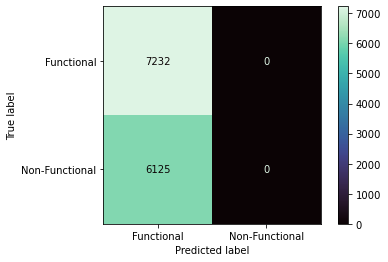

In [120]:
dumbdumbdumb = logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DummyClassifier(strategy='most_frequent'))
])

evaluate(dumbdumbdumb, X_train, X_test, y_train, y_test, cv=5)

Results of Cross-Validation:

Average accuracy: 0.7392063888195658    +/- 0.004427902194403162
Average precision: 0.7799782700976967    +/- 0.0032810013117648695
**Average recall: 0.5977812540138866    +/- 0.012305260075067815
Average f1 score: 0.6767620981245652    +/- 0.008145521358562008
Average roc_auc: 0.8099590590320348    +/- 0.006029401031140267

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 0.740479161467432
Train precision: 0.7821711512383127
**Train recall: 0.598656178302196
Train f1 score: 0.6782188940805148
Train roc_auc: 0.7292123016120425

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7361683012652541
Test precision: 0.7778252510147404
**Test recall: 0.5944489795918367
Test f1 score: 0.6738848787710531
Test roc_auc: 0.7253218349286618


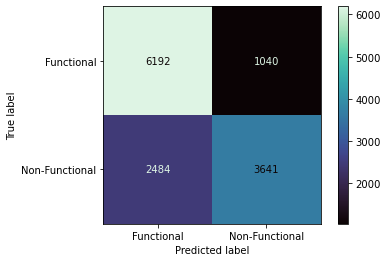

In [121]:
# ~2 minutes
logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=396, max_iter=1000))
])

evaluate(logreg, X_train, X_test, y_train, y_test, cv=5)

Results of Cross-Validation:

Average accuracy: 0.7577738956825555    +/- 0.004950167713787846
Average precision: 0.7337410630172154    +/- 0.007248368655924911
**Average recall: 0.7375178251995923    +/- 0.00692682111960049
Average f1 score: 0.7355908708403478    +/- 0.005007315350745493
Average roc_auc: 0.7561646360021826    +/- 0.0048085443604879465

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 1.0
Train precision: 1.0
**Train recall: 1.0
Train f1 score: 1.0
Train roc_auc: 1.0

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.7583289660851987
Test precision: 0.734726948630692
**Test recall: 0.7402448979591837
Test f1 score: 0.7374756018217308
Test roc_auc: 0.7569449047318042


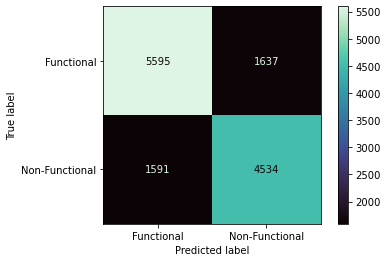

In [122]:
dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=396))
])

evaluate(dt, X_train, X_test, y_train, y_test, cv=5)

Results of Cross-Validation:

Average accuracy: 0.8142001497379585    +/- 0.005237262147072506
Average precision: 0.822432297441831    +/- 0.008215468603354167
**Average recall: 0.7568010101306955    +/- 0.009703850381972872
Average f1 score: 0.7881972882154242    +/- 0.006201610985087064
Average roc_auc: 0.8916793348325548    +/- 0.0030553141410370947

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 1.0
Train precision: 1.0
**Train recall: 1.0
Train f1 score: 1.0
Train roc_auc: 1.0

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.8179980534551171
Test precision: 0.8255199154035954
**Test recall: 0.764734693877551
Test f1 score: 0.7939655903042632
Test roc_auc: 0.8139215504785985


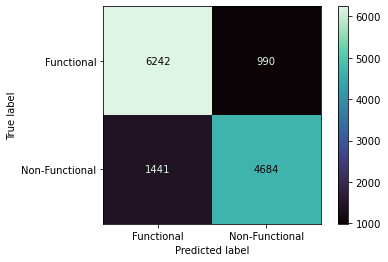

In [123]:
rf1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=396))
])

evaluate(rf, X_train, X_test, y_train, y_test, cv=5)

Results of Cross-Validation:

Average accuracy: 0.8142001497379585    +/- 0.005237262147072506
Average precision: 0.822432297441831    +/- 0.008215468603354167
**Average recall: 0.7568010101306955    +/- 0.009703850381972872
Average f1 score: 0.7881972882154242    +/- 0.006201610985087064
Average roc_auc: 0.8916793348325548    +/- 0.0030553141410370947

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 1.0
Train precision: 1.0
**Train recall: 1.0
Train f1 score: 1.0
Train roc_auc: 1.0

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.8179980534551171
Test precision: 0.8255199154035954
**Test recall: 0.764734693877551
Test f1 score: 0.7939655903042632
Test roc_auc: 0.8139215504785985


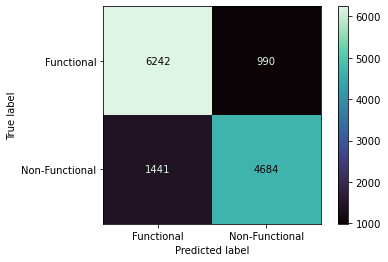

In [130]:
# using CatBoost Encoding
# ~
rf2 = Pipeline(steps=[
    ('preprocessor2', preprocessor2),
    ('classifier', RandomForestClassifier(random_state=396))
])

evaluate(rf, X_train, X_test, y_train, y_test, cv=5)

Results of Cross-Validation:

Average accuracy: 0.8142001497379585    +/- 0.005237262147072506
Average precision: 0.822432297441831    +/- 0.008215468603354167
**Average recall: 0.7568010101306955    +/- 0.009703850381972872
Average f1 score: 0.7881972882154242    +/- 0.006201610985087064
Average roc_auc: 0.8916793348325548    +/- 0.0030553141410370947

++++++++++++++++++++

Results of Train-Test Split Validation:

Training Scores:
Train accuracy: 1.0
Train precision: 1.0
**Train recall: 1.0
Train f1 score: 1.0
Train roc_auc: 1.0

<><><><><><><><><><>

Testing Scores:
Test accuracy: 0.8179980534551171
Test precision: 0.8255199154035954
**Test recall: 0.764734693877551
Test f1 score: 0.7939655903042632
Test roc_auc: 0.8139215504785985


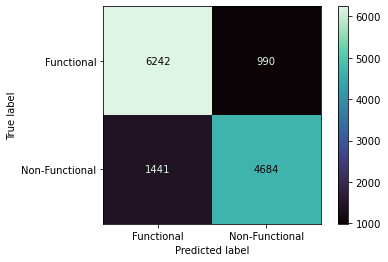

In [124]:
abdt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                                      random_state=396))
])

evaluate(rf, X_train, X_test, y_train, y_test, cv=5)

In [ ]:
test_dict = {'dec_tree':KNeighborsClassifier(), 'lr':LogisticRegression()}

def basic_model_tests(X, y, test_dict):
    '''Takes in X and y data as well as dictionary of name:test entries to run'''
    scores = []
    for key, value in test_dict.items():
        test_model_loop = Pipeline(steps=[
            (key, value)
        ])
        test_model_loop.fit(X, y)
        score = test_model_loop.score(X, y)
        scores.append({'name':key, 'type':value, 'score':score})
    return scores

In [ ]:
test_list = [{'name':'knn', 'type': KNeighborsClassifier(), 'params':{'knn__n_neighbors': [3, 5, 7], 'knn__p': [1, 2, 3]}},
            {'name': 'lr', 'type': LogisticRegression(), 'params':{'lr__fit_intercept':[False], 'lr__C':[1, 1000, 1e12],
                                                                  'lr__solver':['liblinear','newton-cg', 'lbfgs']}}]
#fit_intercept=False, C= 1e12, solver='liblinear'

In [ ]:
def model_tests(X, y, test_list):
    '''Takes in X and y data as well as a list of dictionaries'''
    scores = []
    for x in test_list:
        test_model_loop = Pipeline(steps=[
            (x['name'], x['type'])
        ])
        test_model_loop.fit(X, y)
#         score = test_model_loop.score(X, y)
#         scores.append({'name':x['name'], 'type':x['type'], 'score':score})
        
        gs_pipe = GridSearchCV(estimator=test_model_loop, param_grid=x['params'])
        gs_pipe.fit(X,y)
        scores.append(gs_pipe.cv_results_)
    return scores